# DM Trident Analysis

### 1. Load Libraries and Define General Functions

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import math
import pylhe
import gzip
import shutil
import random

from scipy import interpolate

- function that reads a table in a `.txt` file and converts it to a numpy array

In [2]:
def readfile(filename):
    output= []
    with open(filename) as f:
        for line in f:
            if line[0]=="#":continue
            data = [float(elt.strip()) for elt in line.split( )]
            output.append(data)
    return np.array(output)

- convert a table into input for contour plot

In [3]:
def readdata(ax,
        inputdata, xid, yid, zid, inverted=True, option='sum',
        levels=[1],style="solid",width=0.8,color="k",label="",fill=">",
        extent=None,
        ):
    
    #prepare data 
    data = []
    for line in inputdata:
        x = line[xid-1]-200
        y = line[yid-1]
        if type(zid) is int:
            z = line[zid-1]
        else:
            if option=='sum':
                z = sum([line[zzid-1] for zzid in zid ])
            elif option=='max':
                z = np.max([line[zzid-1] for zzid in zid ])
        if extent is not None:
            if (x<extent[0] or x>extent[1] or y<extent[2] or y>extent[3]): z=0
        data.append([x,y,z])   
    data = np.array(data)
    
    #convert to input
    ntotal=len(data)    
    xval,xvalrow=[],[]
    yval,yvalrow=[],[]
    zval,zvalrow=[],[]
    for iline in range(ntotal):
        line=data[iline]
        save_inv = (inverted is not True and line[0]==data[0,0])   
        save_norm= (inverted is True and line[1]==data[0,1])
        if (iline>0 and (save_inv or save_norm)):
            xval.append(xvalrow)
            yval.append(yvalrow)
            zval.append(zvalrow)
            xvalrow=[]
            yvalrow=[]
            zvalrow=[] 
            
        xvalrow.append(line[0])
        yvalrow.append(line[1])
        zvalrow.append(line[2])
        
    xval.append(xvalrow)
    yval.append(yvalrow)
    zval.append(zvalrow)
        
    xval=np.array(xval)
    yval=np.array(yval)
    zval=np.array(zval)

    if ax is not None:
        if fill==">": 
            ax.contour(xval, yval, zval, levels=levels,colors=color,linestyles=style,linewidths=width)
            ax.contourf(xval, yval, zval, levels=levels+[10**10],colors=color,alpha=alpha)
        #if fill=="<": ax.contourf(xval, yval, zval, levels=[0]+levels,colors=color,alpha=alpha)
        #if fill=="in": ax.contourf(xval, yval, zval, levels=levels,colors=color,alpha=alpha)
        #if fill=="chi2": 
        #    cx = ax.contour(xval, yval, zval-np.amin(zval), levels=[levels[0]],colors=color,linestyles=style,linewidths=width)
        #    ax.contourf(xval, yval, zval-np.amin(zval), levels=levels,colors='none' ,hatches=['//'])
        #    return cx
        ax.plot([10**-10],[10**-10],color=color,label=label,linestyle=style)
    return np.array(xval),np.array(yval),np.array(zval)

- function that combines different datasets from different files

In [4]:
def readdatacombined(ax,
        inputdata, xid, yid, zid, inverted=True, option='sum',
        levels=[1],style="solid",width=0.8,color="k",label="",fill=">",
        extent=None,
        ):
    
    if extent is None:
        extent = [None for d in inputdata]
    
    zvals=[]
    for i in range(len(inputdata)):
        xval,yval,zval = readdata(None,inputdata[i], xid[i], yid[i], zid[i], inverted[i], option,
            levels,style,width,color,label,fill,extent[i])
        zvals.append(zval)
        
        
    newzval = zvals[0] - zvals[0] 
    for i in range(len(zvals[0])):
        for j in range(len(zvals[0][i])):
            vals = [zvals[k][i][j] for k in range(len(zvals))]
            newzval[i,j] = max(vals)
    #newzval=np.array(newzval)
          
    if fill==">":
        ax.contour(xval, yval, newzval, levels=levels,colors=color,linestyles=style,linewidths=width)
        ax.contourf(xval, yval, newzval, levels=levels+[10**10],colors=color,alpha=alpha)
    #if fill=="<": ax.contourf(xval, yval, newzval, levels=[0]+levels,colors=color,alpha=alpha)
    #if fill=="in": ax.contourf(xval, yval, newzval, levels=levels,colors=color,alpha=alpha)
    #if fill=="chi2": 
    #    cx = ax.contour(xval, yval, newzval-np.amin(newzval), levels=[levels[0]],colors=color,linestyles=style,linewidths=width)
    #    ax.contourf(xval, yval, newzval-np.amin(newzval), levels=levels, colors='none' ,hatches=['//'])
    ax.plot([10**-10],[10**-10],color=color,label=label,linestyle=style)

- function that loads the data and then plots it

In [5]:
def load_and_plot(ax,
        filenames, xid, yid, zid, inverted=True, option='sum',
        levels=[1],style="solid",width=0.8,color="k",label="",fill=">",
        extent=None,
        ):
    
    inputdata = [readfile(filename) for filename in filenames]
    readdatacombined(ax,
        inputdata, xid, yid, zid, inverted, option,
        levels,style,width,color,label,fill,
        extent)

- Define Colors and Style

In [6]:
#fontsize
matplotlib.rcParams.update({'font.size': 12})

#Figuresize
figsize=(5.5,5.5)
padleft, padright, padbottom, padtop=0.1,0.985,0.1,0.955
alpha=0.15

#Colors
col_hig,lw_hig,ls_hig= "grey"         ,0.8,"solid"

col_tau,lw_tau,ls_tau= "darkorange"   ,1.2,"dotted"
col_vec,lw_vec,ls_vec= "red"          ,0.8,"solid"
col_gam,lw_gam,ls_gam= "firebrick"    ,1.0,"dashed"
col_top,lw_top,ls_top= "deeppink"     ,1.5,"-."
col_4t,lw_4t,ls_4t = "purple"     ,1.1,"dashed"
col_bot,lw_bot,ls_bot= "red"            ,0.8,"solid"
col_mu,lw_mu,ls_mu= "lightseagreen",1.8,"dashed" #same as Hhh
col_lep,lw_lep,ls_lep= "purple"       ,1.0,"solid"

col_AHZ,lw_AHZ,ls_AHZ= "deepskyblue"  ,1.6,"solid"    
col_AhZ,lw_AhZ,ls_AhZ= "royalblue"    ,1.8,"dashed"  
col_Hhh,lw_Hhh,ls_Hhh= "lightseagreen",1.8,"-."
col_hAA,lw_hAA,ls_hAA= "aqua"         ,2.0,"dotted"


col_ttz,lw_ttz,ls_ttz= "lime"         ,1.0,"solid"

#Colors 
colA,lwA,lsA = "firebrick"    ,1.0,"dashed"
colB,lwB,lsB = "royalblue"    ,1.0,"solid"
colC,lwC,lsC = "limegreen"    ,1.0,"dotted"

# "#87cefa" -> Wei's favorite blue

- functions that set the plotstyles (axisrange, labels, ticks)

In [7]:
def setstyle_m_tb(ax):
    ax.set_yscale("log")
    ax.set_xlim(0,1000)
    ax.set_ylim(0.1,50)
    ax.set_xticks([100,300,500,700,900])
    ax.set_xticklabels(['100','300','500','700','900'])
    ax.set_yticks([0.1,0.5,1,5,10,50])
    ax.set_yticklabels(['0.1','0.5','1','5','10','50'])
    plt.subplots_adjust(left=padleft, right=padright, bottom=padbottom, top=padtop)
    
def setstyle_m_m(ax):
    ax.set_xlim(0,800)
    ax.set_ylim(0,800)
    ax.set_xticks([100,300,500,700])
    ax.set_xticklabels(['100','300','500','700'])
    ax.set_yticks([100,300,500,700])
    ax.set_yticklabels(['100','300','500','700'])
    plt.subplots_adjust(left=padleft, right=padright, bottom=padbottom, top=padtop)
    
def setstyle_tbcba(ax):
    ax.set_yscale("log")
    ax.set_xlim(-.6,.6)
    ax.set_ylim(0.1,50)
    ax.set_xticks([-0.5,-0.25,0,0.25,0.5])
    ax.set_xticklabels(['-0.5','-0.25','0','0.25','0.5'])
    ax.set_yticks([0.1,0.5,1,5,10,50])
    ax.set_yticklabels(['0.1','0.5','1','5','10','50'])
    plt.subplots_adjust(left=padleft, right=padright, bottom=padbottom, top=padtop)    
    
def setstyle_mA_tb(ax):
    ax.set_yscale("log")
    ax.set_xlim(130,800)
    ax.set_ylim(0.1,50)
    ax.set_xticks([100,300,500,700])
    ax.set_xticklabels(['100','300','500','700'])
    ax.set_yticks([0.1,0.5,1,5,10,50])
    ax.set_yticklabels(['0.1','0.5','1','5','10','50'])
    plt.subplots_adjust(left=padleft, right=padright, bottom=padbottom, top=padtop)

### Figure 1

- $h \to AA$: update bound (still wrong)
- $4t$: add channel
- The cutoff of the $H\to tt$, $H \to VV$ and $H \to hh$ lines looks like a stepfunction. That's unphysical. Please make it smoother. 
- Update $\Gamma_{H,A}>0.2$ cutoff for $H \to \tau\tau$ 

### Fig 2
- AHZ: update bounds + CMS 13

### Fig 3
- AHZ: update bounds + CMS 13
- hAA, Gammah: update bounds (probably wrong), extend to m=0

### Fig 4
- A>HZ: update bounds + CMS 13
- mH=50 curve: problem with mH convention in 2HDMC. solution: flip sign of cba for mH<mh (I did that by hand in the _fix file)

### Fig 5
- A>HZ: update bounds + CMS 13
- A>tt search: where does the bound come from? you just require \cot\beta<1.1  
- Is it A or H to gamma gamma / tau tau
- A>HZ doesn't get suppressed at low tanb due to A>tt channel? 

### Fig 6
- A>HZ: update bounds + CMS 13
- add cba=0.05 bounds for type 2 to dropbox
- these are the same Higgs precision constraints as in Fig 1. Is that correct? 

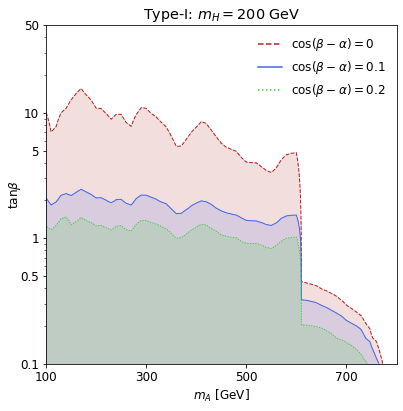

In [8]:
#Prepare Figure
fig, ax = plt.subplots(figsize=figsize)
data1,idma1,idtb1 = readfile("/Users/weisu/Dropbox/LHC_sun_eclipse/FinalPlots/fig6-7/1216_ratio_101_detail.txt"),1,2
data2,idma2,idtb2 = readfile("/Users/weisu/Dropbox/LHC_sun_eclipse/FinalPlots/fig6-7/1216_ratio_10.11_detail.txt"),1,2
data3,idma3,idtb3 = readfile("/Users/weisu/Dropbox/LHC_sun_eclipse/FinalPlots/fig6-7/1216_ratio_10.21_detail.txt"),1,2


#Exotic Higgs
readdata(ax,data1,xid=idma1,yid=idtb1,zid=[42,43,44],inverted=False,option='max',levels=[1],color=colA,style=lsA,width=lwA,label=r"$\cos(\beta-\alpha)=0$")
readdata(ax,data2,xid=idma2,yid=idtb2,zid=[42,43,44],inverted=False,option='max', levels=[1],color=colB,style=lsB,width=lwB,label=r"$\cos(\beta-\alpha)=0.1$")
readdata(ax,data3,xid=idma3,yid=idtb3,zid=[42,43,44],inverted=False,option='max', levels=[1],color=colC,style=lsC,width=lwC,label=r"$\cos(\beta-\alpha)=0.2$")

# load_and_plot(ax,["../research/fig6/matb_ratio_12000.txt","../research/fig6/matb_ratio13_12000.txt"],
#     xid=[1,1],yid=[2,2],zid=[5,5],inverted=[False,False],extent=[None,None],
#     color=colA,style=lsA,width=lwA,label=r"$\cos(\beta-\alpha)=0$")

# load_and_plot(ax,["../research/fig6/matb_ratio_12000.1.txt","../research/fig6/matb_ratio13_12000.1.txt"],
#     xid=[1,1],yid=[2,2],zid=[5,5],inverted=[False,False],extent=[None,None],
#     color=colB,style=lsB,width=lwB,label=r"$\cos(\beta-\alpha)=0.1$")

# load_and_plot(ax,["../research/fig6/matb_ratio_12000.2.txt","../research/fig6/matb_ratio13_12000.2.txt"],
#     xid=[1,1],yid=[2,2],zid=[5,5],inverted=[False,False],extent=[None,None],
#     color=colC,style=lsC,width=lwC,label=r"$\cos(\beta-\alpha)=0.2$")
 
ax.set_xlabel(r"$m_A$ [GeV]")
ax.set_ylabel(r'$\tan\beta$',labelpad=-3)
ax.set_title(r'Type-I: $m_H=200$ GeV',)
ax.legend(frameon=False,loc="upper right")
setstyle_mA_tb(ax)
fig.savefig('figc1A.pdf')

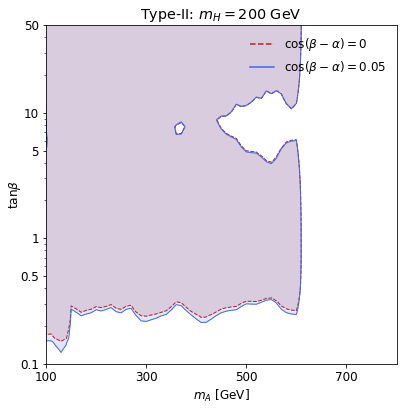

In [9]:
# data1,idmH1,idtb1 = readfile("../research/fig7/ratio_22000.051_detail.txt"),1,2

#Prepare Figure
fig, ax = plt.subplots(figsize=figsize)

data1,idma1,idtb1 = readfile("/Users/weisu/Dropbox/LHC_sun_eclipse/FinalPlots/fig6-7/1216_ratio_201_detail.txt"),1,2
data2,idma2,idtb2 = readfile("/Users/weisu/Dropbox/LHC_sun_eclipse/FinalPlots/fig6-7/1216_ratio_20.051_detail.txt"),1,2
# data3,idma3,idtb3 = readfile("/Users/weisu/Dropbox/LHC_sun_eclipse/FinalPlots/fig6-7/1216_ratio_10.21_detail.txt"),1,2


#Exotic Higgs
readdata(ax,data1,xid=idma1,yid=idtb1,zid=[42,43,44],inverted=False,option='max',levels=[1],color=colA,style=lsA,width=lwA,label=r"$\cos(\beta-\alpha)=0$")
readdata(ax,data2,xid=idma2,yid=idtb2,zid=[42,43,44],inverted=False,option='max', levels=[1],color=colB,style=lsB,width=lwB,label=r"$\cos(\beta-\alpha)=0.05$")
# readdata(ax,data3,xid=idma3,yid=idtb3,zid=[42,43,44],inverted=False,option='max', levels=[1],color=colC,style=lsC,width=lwC,label=r"$\cos(\beta-\alpha)=0.2$")
 
ax.set_xlabel(r"$m_A$ [GeV]")
ax.set_ylabel(r'$\tan\beta$',labelpad=-3)
ax.set_title(r'Type-II: $m_H=200$ GeV',)
ax.legend(frameon=False,loc="upper right")
setstyle_mA_tb(ax)
fig.savefig('figc1B.pdf')

### Fig 7
- A>HZ: update bounds + CMS 13
- A>tt search: update bounds
- make gap for $h\to AA$ and $\Gamma_h$ more finegrained, also extent to smaller masses 
- why for $A\to hZ$ and $A \to HZ$ do you add up two columns?
- where is the 8TeV HAZ bound for type 2 stored? 

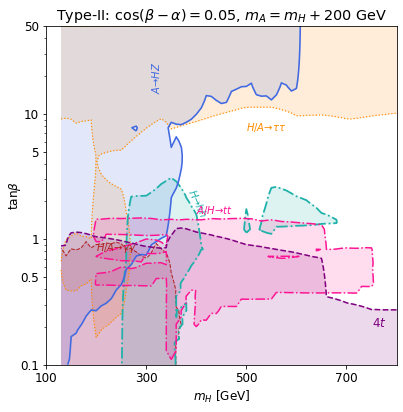

In [52]:
#Load Data
# data1,idmH1,idtb1 = readfile("../research/fig7/ratio_22000.051_detail.txt"),1,2
# data2,idmH2,idtb2 = readfile("../research/fig7/matb_22000.05.txt"),3,5
data1,idma1,idtb1 = readfile("/Users/weisu/Documents/research/project/114a/LHC_HZA/1new_code/My2HDMC0408/data_matb_1001_AHZ/2020jun25_ratio_20.051_detail.txt"),1,2
#Prepare Figure
fig, ax = plt.subplots(figsize=figsize)

#Precision
# val=10**0.4
# ax.plot([62,999],[val,val],color=col_hig,lw=0.8)
# ax.fill_between([62,999],[val/0.8,val/0.8],[val,val], facecolor="none", hatch="//", edgecolor=col_hig, lw=0)
# plt.text(730, 0.43, r"$\mu_h$", fontsize=12,color=col_hig,rotation=0)
# val=10**-0.4
# ax.plot([62,999],[val,val],color=col_hig,lw=0.8)
# ax.fill_between([62,999],[val*0.8,val*0.8],[val,val], facecolor="none", hatch="//", edgecolor=col_hig, lw=0)
# plt.text(730, 2, r"$\mu_h$", fontsize=12,color=col_hig,rotation=0)

# readdata(ax,data1,xid=idma1,yid=idtb1,zid=[47],inverted=False,option='max',
#     levels=[9],color=col_hig,style=ls_hig,width=lw_hig)
# plt.text(40, 3.6, r"$\Gamma_h$", fontsize=12,color=col_hig,rotation=90)

#Conevtional
readdata(ax,data1,xid=idma1,yid=idtb1,zid=[9,10,11,12],inverted=False,option='max',
    levels=[1],color=col_tau,style=ls_tau,width=lw_tau,extent=[90,1000,0.1,50])
# readdata(ax,data1,xid=idma1,yid=idtb1,zid=[9,10,11,12],inverted=False,option='max',
#     levels=[1],color=col_tau,style=ls_tau,width=lw_tau,extent=[20,70,0.1,50])
# plt.text(100, 4.5, r"$H/A\to \tau\tau$", fontsize=10,color=col_tau,rotation=110)
plt.text(500, 7.3, r"$H/A\to \tau\tau$", fontsize=10,color=col_tau,rotation=0)

readdata(ax,data1,xid=idma1,yid=idtb1,zid=[13,14,15,16],inverted=False,option='max',
    levels=[0.99],color=col_gam,style=ls_gam,width=lw_gam,extent=[130,1000,0.1,50])
plt.text(200, 0.8, r"$H/A\to \gamma\gamma$", fontsize=10,color=col_gam,rotation=0)

#Exotic Higgs
# readdata(ax,data1,xid=idma1,yid=idtb1,zid=[38,39,40],inverted=False,option='sum',
#     levels=[0.99],color=col_AHZ,style=ls_AhZ,width=lw_AhZ)
# plt.text(225, 0.2, r"$A\to hZ$", fontsize=10,color=col_AHZ,rotation=90)
#  the color set here is for in same as up

readdata(ax,data1,xid=idma1,yid=idtb1,zid=41,inverted=False,
    levels=[1],color=col_Hhh,style=ls_Hhh,width=lw_Hhh)
plt.text(380, 1.5, r"$H \to hh$", fontsize=10,color=col_Hhh,rotation=-65)

readdata(ax,data1,xid=idma1,yid=idtb1,zid=[42,43,44],inverted=False,option='max',
     levels=[1],color=col_AhZ,style=ls_AHZ,width=lw_AHZ)
plt.text(308, 15, r"$A\to HZ$", fontsize=10,color=col_AhZ,rotation=90)
# plt.text(103, 15, r"$A\to HZ$", fontsize=10,color=col_AhZ,rotation=90)

# readdata(ax,data1,xid=idma1,yid=idtb1,zid=[28,29,30,31,32,33,34,35],inverted=False,option='max',
#     levels=[0.3],color=col_hAA,style=ls_hAA,width=lw_hAA)
# plt.text(75, 3.5, r"$h \to AA$", fontsize=10,color=col_hAA,rotation=90)


readdata(ax,data1,xid=idma1,yid=idtb1,zid=[17,18,19,20],inverted=False,option='max',
    levels=[1.03],color=col_top,style=ls_top,width=lw_top,extent=[200,1000,0.1,50])
plt.text(400, 1.58, r"$A/H \to tt$", fontsize=10,color=col_top,rotation=0)

readdata(ax,data1,xid=idma1,yid=idtb1,zid=[21,22,23,24],inverted=False,option='max',
    levels=[1],color=col_4t,style=ls_4t,width=lw_4t*1.4)
plt.text(750, 0.2, r"$4t$", fontsize=12,color=col_4t,rotation=0)

ax.set_xlabel(r"$m_H$ [GeV]")
ax.set_ylabel(r'$\tan\beta$',labelpad=-3)
ax.set_title(r'Type-II: $\cos(\beta-\alpha)=0.05$, $m_A=m_H+200$ GeV')
setstyle_mA_tb(ax)
fig.savefig('figc2B.pdf')

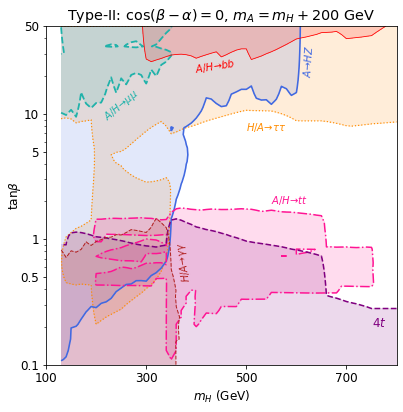

In [8]:
#Load Data
# data1,idmH1,idtb1 = readfile("../research/fig7/ratio_22000.051_detail.txt"),1,2
# data2,idmH2,idtb2 = readfile("../research/fig7/matb_22000.05.txt"),3,5
data1,idma1,idtb1 = readfile("/Users/weisu/Documents/research/project/114a/LHC_HZA/1new_code/My2HDMC0408/data_matb_1001_AHZ/2020jun25_ratio_201_detail.txt"),1,2
#Prepare Figure
fig, ax = plt.subplots(figsize=figsize)

#Precision
# val=10**0.4
# ax.plot([62,999],[val,val],color=col_hig,lw=0.8)
# ax.fill_between([62,999],[val/0.8,val/0.8],[val,val], facecolor="none", hatch="//", edgecolor=col_hig, lw=0)
# plt.text(730, 0.43, r"$\mu_h$", fontsize=12,color=col_hig,rotation=0)
# val=10**-0.4
# ax.plot([62,999],[val,val],color=col_hig,lw=0.8)
# ax.fill_between([62,999],[val*0.8,val*0.8],[val,val], facecolor="none", hatch="//", edgecolor=col_hig, lw=0)
# plt.text(730, 2, r"$\mu_h$", fontsize=12,color=col_hig,rotation=0)

# readdata(ax,data1,xid=idma1,yid=idtb1,zid=[47],inverted=False,option='max',
#     levels=[9],color=col_hig,style=ls_hig,width=lw_hig)
# plt.text(40, 3.6, r"$\Gamma_h$", fontsize=12,color=col_hig,rotation=90)

#Conevtional
readdata(ax,data1,xid=idma1,yid=idtb1,zid=[9,10,11,12],inverted=False,option='max',
    levels=[1],color=col_tau,style=ls_tau,width=lw_tau,extent=[90,1000,0.1,50])
# readdata(ax,data1,xid=idma1,yid=idtb1,zid=[9,10,11,12],inverted=False,option='max',
#     levels=[1],color=col_tau,style=ls_tau,width=lw_tau,extent=[20,70,0.1,50])
# plt.text(100, 4.5, r"$H/A\to \tau\tau$", fontsize=10,color=col_tau,rotation=110)
plt.text(500, 7.3, r"$H/A\to \tau\tau$", fontsize=10,color=col_tau,rotation=0)



#Exotic Higgs
# readdata(ax,data1,xid=idma1,yid=idtb1,zid=[38,39,40],inverted=False,option='sum',
#     levels=[0.99],color=col_AHZ,style=ls_AhZ,width=lw_AhZ)
# plt.text(225, 0.2, r"$A\to hZ$", fontsize=10,color=col_AHZ,rotation=90)
#  the color set here is for in same as up

# readdata(ax,data1,xid=idma1,yid=idtb1,zid=41,inverted=False,
#     levels=[1],color=col_Hhh,style=ls_Hhh,width=lw_Hhh)
# plt.text(380, 1.5, r"$H \to hh$", fontsize=10,color=col_Hhh,rotation=-65)

readdata(ax,data1,xid=idma1,yid=idtb1,zid=[42,43,44],inverted=False,option='max',
     levels=[1],color=col_AhZ,style=ls_AHZ,width=lw_AHZ)
plt.text(610, 20, r"$A\to HZ$", fontsize=10,color=col_AhZ,rotation=86)
# plt.text(103, 15, r"$A\to HZ$", fontsize=10,color=col_AhZ,rotation=90)

# readdata(ax,data1,xid=idma1,yid=idtb1,zid=[28,29,30,31,32,33,34,35],inverted=False,option='max',
#     levels=[0.3],color=col_hAA,style=ls_hAA,width=lw_hAA)
# plt.text(75, 3.5, r"$h \to AA$", fontsize=10,color=col_hAA,rotation=90)
readdata(ax,data1,xid=idma1,yid=idtb1,zid=[3,4,5,6],inverted=False,
    levels=[1],color=col_mu,style=ls_mu,width=lw_mu,extent=[100,350,0.1,50])
plt.text(210, 8.9, r"$A/H \to \mu\mu$", fontsize=10,color=col_mu,rotation=40)

readdata(ax,data1,xid=idma1,yid=idtb1,zid=[7,8],inverted=False,
    levels=[1],color=col_bot,style=ls_bot,width=lw_bot,extent=[300,1000,0.1,50])
plt.text(395, 21, r"$A/H \to bb$", fontsize=10,color=col_bot,rotation=9)

readdata(ax,data1,xid=idma1,yid=idtb1,zid=[17,18,19,20],inverted=False,option='max',
    levels=[1.03],color=col_top,style=ls_top,width=lw_top,extent=[200,1000,0.1,50])
plt.text(550, 1.9, r"$A/H \to tt$", fontsize=10,color=col_top,rotation=0)

readdata(ax,data1,xid=idma1,yid=idtb1,zid=[21,22,23,24],inverted=False,option='max',
    levels=[1],color=col_4t,style=ls_4t,width=lw_4t*1.4)
plt.text(750, 0.2, r"$4t$", fontsize=12,color=col_4t,rotation=0)

readdata(ax,data1,xid=idma1,yid=idtb1,zid=[13,14,15,16],inverted=False,option='max',
    levels=[0.99],color=col_gam,style=ls_gam,width=lw_gam,extent=[130,1000,0.1,50])
plt.text(355, 0.48, r"$H/A\to \gamma\gamma$", fontsize=10,color=col_gam,rotation=99)

ax.set_xlabel(r"$m_H$ (GeV)")
ax.set_ylabel(r'$\tan\beta$',labelpad=-3)
ax.set_title(r'Type-II: $\cos(\beta-\alpha)=0$, $m_A=m_H+200$ GeV')
setstyle_mA_tb(ax)
fig.savefig('figc2D.pdf')

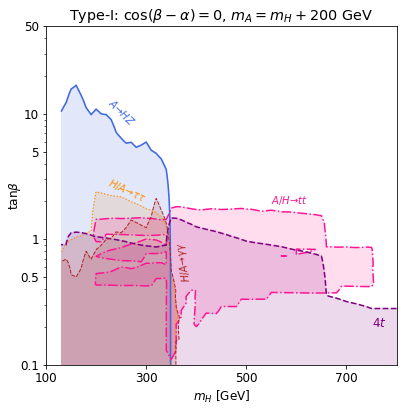

In [57]:
#Load Data
# data1,idmH1,idtb1 = readfile("../research/fig7/ratio_22000.051_detail.txt"),1,2
# data2,idmH2,idtb2 = readfile("../research/fig7/matb_22000.05.txt"),3,5
data1,idma1,idtb1 = readfile("/Users/weisu/Documents/research/project/114a/LHC_HZA/1new_code/My2HDMC0408/data_matb_1001_AHZ/2020jun25_ratio_101_detail.txt"),1,2
#Prepare Figure
fig, ax = plt.subplots(figsize=figsize)


#Conevtional
readdata(ax,data1,xid=idma1,yid=idtb1,zid=[9,10,11,12],inverted=False,option='max',
    levels=[1],color=col_tau,style=ls_tau,width=lw_tau,extent=[90,1000,0.1,50])
plt.text(220, 2., r"$H/A\to \tau\tau$", fontsize=10,color=col_tau,rotation=335)



readdata(ax,data1,xid=idma1,yid=idtb1,zid=[42,43,44],inverted=False,option='max',
     levels=[1],color=col_AhZ,style=ls_AHZ,width=lw_AHZ)
plt.text(220, 8, r"$A\to HZ$", fontsize=10,color=col_AhZ,rotation=315)


readdata(ax,data1,xid=idma1,yid=idtb1,zid=[17,18,19,20],inverted=False,option='max',
    levels=[1.03],color=col_top,style=ls_top,width=lw_top,extent=[200,1000,0.1,50])
plt.text(550, 1.9, r"$A/H \to tt$", fontsize=10,color=col_top,rotation=0)

# readdata(ax,data1,xid=idma1,yid=idtb1,zid=[3,4,5,6],inverted=False,
#     levels=[1],color=col_mu,style=ls_mu,width=lw_mu,extent=[100,350,0.1,50])
# plt.text(210, 8.9, r"$A/H \to \mu\mu$", fontsize=10,color=col_mu,rotation=40)

# readdata(ax,data1,xid=idma1,yid=idtb1,zid=[7,8],inverted=False,
#     levels=[1],color=col_bot,style=ls_bot,width=lw_bot,extent=[300,1000,0.1,50])
# plt.text(395, 21, r"$A/H \to bb$", fontsize=10,color=col_bot,rotation=9)

readdata(ax,data1,xid=idma1,yid=idtb1,zid=[21,22,23,24],inverted=False,option='max',
    levels=[1],color=col_4t,style=ls_4t,width=lw_4t*1.4)
plt.text(750, 0.2, r"$4t$", fontsize=12,color=col_4t,rotation=0)

readdata(ax,data1,xid=idma1,yid=idtb1,zid=[13,14,15,16],inverted=False,option='max',
    levels=[0.99],color=col_gam,style=ls_gam,width=lw_gam,extent=[130,1000,0.1,50])
plt.text(355, 0.48, r"$H/A\to \gamma\gamma$", fontsize=10,color=col_gam,rotation=99)

ax.set_xlabel(r"$m_H$ (GeV)")
ax.set_ylabel(r'$\tan\beta$',labelpad=-3)
ax.set_title(r'Type-I: $\cos(\beta-\alpha)=0$, $m_A=m_H+200$ GeV')
setstyle_mA_tb(ax)
fig.savefig('figc2C.pdf')